In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import math
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
data_path = "/content/drive/MyDrive/Unified Mentors/Heart Disease/dataset.csv"

In [45]:
data = pd.read_csv(data_path)

In [46]:
data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


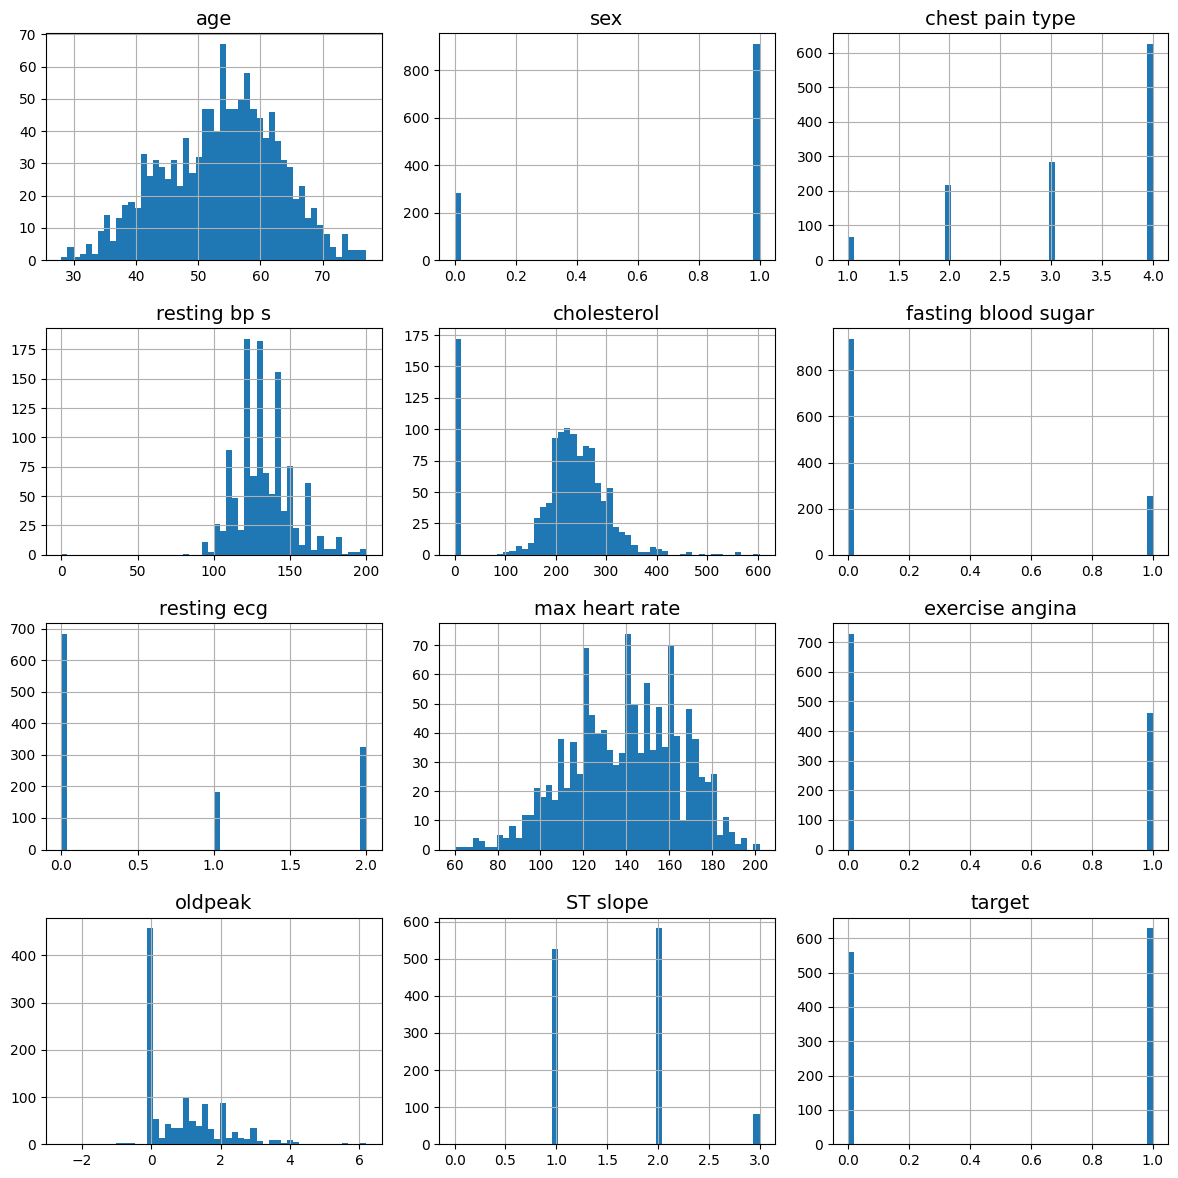

In [48]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

num_columns = len(data.columns)
plots_per_row = 3
num_rows = math.ceil(num_columns / plots_per_row)

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 4, num_rows * 3))

axes = axes.flatten()

for i, column in enumerate(data.columns):
    data[column].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'{column}')

for j in range(num_columns, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [49]:
X = data.drop('target' , axis = 1)
y = data['target']

In [50]:
from sklearn.preprocessing import StandardScaler , OrdinalEncoder , OneHotEncoder , FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [51]:
numeric_features = ["age" , "resting bp s" , "cholesterol" , "max heart rate" , "oldpeak"]
binary_features = ["sex" , "fasting blood sugar" , "exercise angina"]
categorical_features = ["chest pain type" , "resting ecg" , "ST slope"]

In [52]:
default_numeric_pipeline = Pipeline(steps=[
    ("scaler" , StandardScaler())
])
default_binary_pipeline = Pipeline(steps=[
    ("binary" , OrdinalEncoder())
])
default_categorical_pipeline = Pipeline(steps=[
    ("onehot" , OneHotEncoder())
])

def add_one(x):
    return x + 1

def log_transform(x):
    return np.log(x)

log_pipeline = Pipeline(steps=[
    ("add_one", FunctionTransformer(add_one , feature_names_out="one-to-one")),
    ("log" , FunctionTransformer(log_transform , feature_names_out="one-to-one")),
    ("scaler" , StandardScaler())
])
rbf_pipeline = Pipeline(steps=[
    ("rbf" , FunctionTransformer(rbf_kernel , kw_args=dict(Y=[[0]], gamma=0.5) ,feature_names_out="one-to-one")),
    ("scaler" , StandardScaler())
])

In [53]:
preprocessor = ColumnTransformer( transformers = [
    ("def_num" , default_numeric_pipeline , ["age" , "resting bp s" , "cholesterol"]),
    ("def_cat" , default_categorical_pipeline , categorical_features),
    ("def_bin" , default_binary_pipeline , binary_features),
    ("log" , log_pipeline , ["max heart rate"]),
    ("rbf" , rbf_pipeline , ["oldpeak"])

])

In [54]:
x = preprocessor.fit_transform(X)
x.shape

(1190, 19)

In [55]:
print(preprocessor.get_feature_names_out())

['def_num__age' 'def_num__resting bp s' 'def_num__cholesterol'
 'def_cat__chest pain type_1' 'def_cat__chest pain type_2'
 'def_cat__chest pain type_3' 'def_cat__chest pain type_4'
 'def_cat__resting ecg_0' 'def_cat__resting ecg_1'
 'def_cat__resting ecg_2' 'def_cat__ST slope_0' 'def_cat__ST slope_1'
 'def_cat__ST slope_2' 'def_cat__ST slope_3' 'def_bin__sex'
 'def_bin__fasting blood sugar' 'def_bin__exercise angina'
 'log__max heart rate' 'rbf__oldpeak']


In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [57]:
logistic_reg_clf = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , LogisticRegression(random_state=42))
])

In [58]:
svm_clf = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , SVC(kernel="poly", degree=5, coef0=1, C=5 ,  probability=True , random_state=42))
])

In [59]:
random_forest_clf = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , RandomForestClassifier(n_estimators=100, random_state=42))
])

In [60]:
gradient_boosting_clf = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
])

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [62]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [63]:
logistic_reg_clf.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('def_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting bp s',
                                                   'cholesterol']),
                                                 ('def_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['chest pain type',
                                                   'resting ecg', 'ST slope']),
                                                 ('def_bin',
                                                  Pipeline(steps=[('binary',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'fasting blood sugar',
                                                   'exercise an...
                                                                                       func=<function log_transform at 0x7858266f6020>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max heart rate']),
                                                 ('rbf',
                                                  Pipeline(steps=[('rbf',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x785845b79580>,
                                                                                       kw_args={'Y': [[0]],
                                                                                                'gamma': 0.5})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['oldpeak'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [64]:
y_pred_lr = logistic_reg_clf.predict(X_test)
print("Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, logistic_reg_clf.predict_proba(X_test)[:, 1]):.4f}")

Logistic Regression Evaluation:
Accuracy: 0.8697
Precision: 0.8676
Recall: 0.9008
F1-Score: 0.8839
ROC AUC Score: 0.9334


In [65]:
svm_clf.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('def_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting bp s',
                                                   'cholesterol']),
                                                 ('def_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['chest pain type',
                                                   'resting ecg', 'ST slope']),
                                                 ('def_bin',
                                                  Pipeline(steps=[('binary',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'fasting blood sugar',
                                                   'exercise an...
                                                                                       func=<function log_transform at 0x7858266f6020>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max heart rate']),
                                                 ('rbf',
                                                  Pipeline(steps=[('rbf',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x785845b79580>,
                                                                                       kw_args={'Y': [[0]],
                                                                                                'gamma': 0.5})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['oldpeak'])])),
                ('classifier',
                 SVC(C=5, coef0=1, degree=5, kernel='poly', probability=True,
                     random_state=42))])

In [66]:
y_pred_svm = svm_clf.predict(X_test)
print("SVC Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_svm):.4f}")
y_score_svm = svm_clf.predict_proba(X_test)[:, 1]
print(f"ROC AUC Score: {roc_auc_score(y_test, y_score_svm):.4f}")

SVC Evaluation:
Accuracy: 0.8866
Precision: 0.9127
Recall: 0.8779
F1-Score: 0.8949
ROC AUC Score: 0.9271


In [67]:
random_forest_clf.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('def_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting bp s',
                                                   'cholesterol']),
                                                 ('def_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['chest pain type',
                                                   'resting ecg', 'ST slope']),
                                                 ('def_bin',
                                                  Pipeline(steps=[('binary',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'fasting blood sugar',
                                                   'exercise an...
                                                                                       func=<function log_transform at 0x7858266f6020>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max heart rate']),
                                                 ('rbf',
                                                  Pipeline(steps=[('rbf',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x785845b79580>,
                                                                                       kw_args={'Y': [[0]],
                                                                                                'gamma': 0.5})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['oldpeak'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [68]:
y_pred_rf = random_forest_clf.predict(X_test)
print("Random Forest Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, random_forest_clf.predict_proba(X_test)[:, 1]):.4f}")

Random Forest Evaluation:
Accuracy: 0.9496
Precision: 0.9474
Recall: 0.9618
F1-Score: 0.9545
ROC AUC Score: 0.9718


In [69]:
gradient_boosting_clf.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('def_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting bp s',
                                                   'cholesterol']),
                                                 ('def_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['chest pain type',
                                                   'resting ecg', 'ST slope']),
                                                 ('def_bin',
                                                  Pipeline(steps=[('binary',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'fasting blood sugar',
                                                   'exercise an...
                                                                                       func=<function log_transform at 0x7858266f6020>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max heart rate']),
                                                 ('rbf',
                                                  Pipeline(steps=[('rbf',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x785845b79580>,
                                                                                       kw_args={'Y': [[0]],
                                                                                                'gamma': 0.5})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['oldpeak'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [70]:
y_pred_gb = gradient_boosting_clf.predict(X_test)
print("Gradient Boosting Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, gradient_boosting_clf.predict_proba(X_test)[:, 1]):.4f}")

Gradient Boosting Evaluation:
Accuracy: 0.9202
Precision: 0.9118
Recall: 0.9466
F1-Score: 0.9288
ROC AUC Score: 0.9611


## Conclusion
Looking at the metrices of all the four models performance on the test set we can tell that **Random Forest Classifier** `(F1-Score: 0.9545)` is out-performing other three models by a significant margin

## Hyperparameter Tuning

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
full_pipeline = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , RandomForestClassifier(random_state=42))
])

param_grid = [
    {
        "classifier__n_estimators" : [100, 200, 300],
        "classifier__max_depth" : [None, 10, 20, 30],
        "classifier__min_samples_split" : [2, 5, 10],
        "classifier__min_samples_leaf" : [1, 2, 4],
        "classifier__max_features" : ['sqrt', 'log2'],
        "classifier__criterion" : ['gini', 'entropy']
    }
]

In [73]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='roc_auc' , n_jobs = -1)
grid_search.fit(X_train, y_train)
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan

Best parameters found by GridSearchCV:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


In [74]:
# grid_search.cv_results_

In [75]:
best_clf = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , RandomForestClassifier(n_estimators=100,
                                           criterion='gini',
                                           max_depth=None ,
                                           max_features='sqrt',
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           random_state=42))
])

In [76]:
best_clf.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('def_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting bp s',
                                                   'cholesterol']),
                                                 ('def_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['chest pain type',
                                                   'resting ecg', 'ST slope']),
                                                 ('def_bin',
                                                  Pipeline(steps=[('binary',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'fasting blood sugar',
                                                   'exercise an...
                                                                                       func=<function log_transform at 0x7858266f6020>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max heart rate']),
                                                 ('rbf',
                                                  Pipeline(steps=[('rbf',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x785845b79580>,
                                                                                       kw_args={'Y': [[0]],
                                                                                                'gamma': 0.5})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['oldpeak'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [77]:
y_pred_rf = best_clf.predict(X_test)
y_pred_tr = best_clf.predict(X_train)
print("Best Random Forest Evaluation:")
print(f"Traning Accuracy: {accuracy_score(y_train, y_pred_tr):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, random_forest_clf.predict_proba(X_test)[:, 1]):.4f}")

Best Random Forest Evaluation:
Traning Accuracy: 1.0000
Test Accuracy: 0.9496
Precision: 0.9474
Recall: 0.9618
F1-Score: 0.9545
ROC AUC Score: 0.9718


In [84]:
full_pipeline = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , SVC(random_state=42))
])

param_grid = [
    {
        "classifier__C" : [ 0.1, 1, 10,5,20,50 ,100 ],
        "classifier__kernel" : ['poly', 'rbf'],
        "classifier__degree" : [2, 3, 4,5],
        "classifier__gamma" : ['scale', 'auto'],
        "classifier__coef0" : [0.0, 0.1, 0.5, 1.0],
    }
]

In [85]:
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='roc_auc' , n_jobs = -1)
grid_search.fit(X_train, y_train)
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'classifier__C': 0.1, 'classifier__coef0': 0.0, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan

In [87]:
best_svc_clf = Pipeline(steps=[
    ("preprocessor" , preprocessor),
    ("classifier" , SVC(C=0.1,
                        coef0=0.0,
                        degree=2,
                        gamma='scale',
                        kernel='poly',
                        probability=True,
                        random_state=42
                        ))
])

In [88]:
best_svc_clf.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('def_num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'resting bp s',
                                                   'cholesterol']),
                                                 ('def_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['chest pain type',
                                                   'resting ecg', 'ST slope']),
                                                 ('def_bin',
                                                  Pipeline(steps=[('binary',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'fasting blood sugar',
                                                   'exercise an...
                                                                                       func=<function log_transform at 0x7858266f6020>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['max heart rate']),
                                                 ('rbf',
                                                  Pipeline(steps=[('rbf',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x785845b79580>,
                                                                                       kw_args={'Y': [[0]],
                                                                                                'gamma': 0.5})),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['oldpeak'])])),
                ('classifier',
                 SVC(C=0.1, degree=2, kernel='poly', probability=True,
                     random_state=42))])

In [89]:
y_pred_rf = best_svc_clf.predict(X_test)
y_pred_tr = best_svc_clf.predict(X_train)
print("Best Support Vector Classifier Evaluation:")
print(f"Traning Accuracy: {accuracy_score(y_train, y_pred_tr):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
y_score_svm = svm_clf.predict_proba(X_test)[:, 1]
print(f"ROC AUC Score: {roc_auc_score(y_test, y_score_svm):.4f}")

Best Support Vector Classifier Evaluation:
Traning Accuracy: 0.8571
Test Accuracy: 0.8782
Precision: 0.8864
Recall: 0.8931
F1-Score: 0.8897
ROC AUC Score: 0.9271


### Conclusion
Looks like the deafult `random_forest_clf` was good enough.

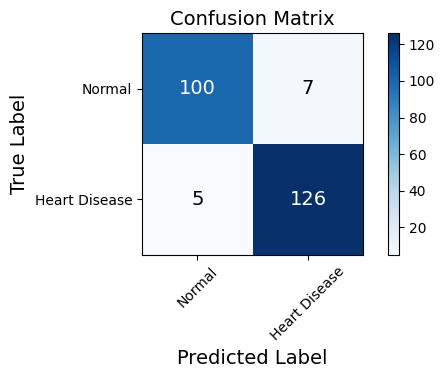

In [90]:
from sklearn.metrics import confusion_matrix

# Predict
y_pred = best_clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = ["Normal", "Heart Disease"]

plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate the cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [78]:
import joblib

In [79]:
joblib.dump(best_clf , "best_clf.pkl")

['best_clf.pkl']